# Apple Image Classification with Transfer Learning & Fine Tuning

## Business Problem

In this notebook, we build a deep learning model to classify different types of apples using a Convolutional Neural Network (CNN), **Transfer Learning** and **Fine-Tuning** techniques. 

The dataset is a subset of the [Fruits 360 dataset on Kaggle](https://www.kaggle.com/moltean/fruits), which originally contains over 100 fruit types. For this task, we focus only on apples, with 13 classes and approximately 200 images per class.

The approach leverages a **pretrained ResNet50** model with weights from ImageNet, fine-tuned for our specific classification task.


## Project Goals

- Load and pre-process the apple subset of the dataset.
- Explore the dataset structure and class distribution.
- Implement a Transfer Learning and a Fine-Tuning pipeline using ResNet50.
- Train, validate and evaluate the model.
- Visualize performance with confusion matrices and sample predictions.
- Discuss results and potential improvements.


## Import Libraries


In [ ]:
import os
import sys
from time import time

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, decode_predictions

root_path = os.path.abspath(os.path.join(os.getcwd(), "..")) 
if os.path.exists(root_path) and root_path not in sys.path: 
    sys.path.append(root_path)

from utils import consolepy

## Data Collection

We will create the *X* and *y* sets for **train** and **test** from the data, taking into account their distribution. To do this, we will:

- Explore the dataset structure.
- Create a train/test split with a resolution of 32x32.
- Create an additional test set with a resolution of 224x224.

In [2]:
# Unzip files
zip_files = [
    "../data/apple/apple_train.zip",
    "../data/apple/apple_test.zip"
    ]

for zip_file in zip_files:
    consolepy.unzip_files(zip_file, "../data/apple/")

Extracted ../data/apple/apple_train.zip to ../data/apple/
Extracted ../data/apple/apple_test.zip to ../data/apple/


In [3]:
# Import data
TRAIN_PATH = "../data/apple/apple_train"
TEST_PATH = "../data/apple/apple_test"

# Images resolution
IM_SIZE_LQ = 32
IM_SIZE_HQ = 224

In [4]:
# Load train images and labels, with Low Quality (LQ)
X_train = []
y_train = []

for category in os.listdir(TRAIN_PATH):
    print("Reading:", category)
    for file in os.listdir(os.path.join(TRAIN_PATH, category)):
        img = plt.imread(os.path.join(TRAIN_PATH, category, file))
        img = cv2.resize(img, (IM_SIZE_LQ, IM_SIZE_LQ))
        X_train.append(img)
        y_train.append(category)
        
# Convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# Verify the shape of the data
print(X_train.shape)
print(y_train.shape)

# Save the data
np.save("../data/apple/X_train.npy", X_train)
np.save("../data/apple/y_train.npy", y_train)


Reading: Braeburn
Reading: CrimsonSnow
Reading: Golden1
Reading: Golden2
Reading: Golden3
Reading: GrannySmith
Reading: PinkLady
Reading: Red1
Reading: Red2
Reading: Red3
Reading: RedDelicious
Reading: RedYellow1
Reading: RedYellow2
(6404, 32, 32, 3)
(6404,)


In [5]:
# Load test data with Low Quality (LQ)
X_test = []
y_test = []

for category in os.listdir(TEST_PATH):
    print("Reading:", category)
    for file in os.listdir(os.path.join(TEST_PATH, category)):
        img = plt.imread(os.path.join(TEST_PATH, category, file))
        img = cv2.resize(img, (IM_SIZE_LQ, IM_SIZE_LQ))
        X_test.append(img)
        y_test.append(category)

# Transform the data into numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

# Verify the shape of the data
print(X_test.shape)
print(y_test.shape)

# Save the data
np.save("../data/apple/X_test.npy", X_test)
np.save("../data/apple/y_test.npy", y_test)


Reading: Braeburn
Reading: CrimsonSnow
Reading: Golden1
Reading: Golden2
Reading: Golden3
Reading: GrannySmith
Reading: PinkLady
Reading: Red1
Reading: Red2
Reading: Red3
Reading: RedDelicious
Reading: RedYellow1
Reading: RedYellow2
(2134, 32, 32, 3)
(2134,)


We have a large number of apple images. They are in color and have a resolution of 32x32. Before starting with the visualization, we also create the high-resolution test set (224x224) to apply Zero-Shot Learning with ResNet50, which requires that input size.

In [6]:
# Load test images and labels, with High Quality (HQ)
X_test_224 = []
y_test_224 = []

for category in os.listdir(TEST_PATH):
    print("Reading:", category)
    for file in os.listdir(os.path.join(TEST_PATH, category)):
        img = plt.imread(os.path.join(TEST_PATH, category, file))
        img = cv2.resize(img, (IM_SIZE_HQ, IM_SIZE_HQ))
        X_test_224.append(img)
        y_test_224.append(category)

# Transform the data into numpy arrays
X_test_224 = np.array(X_test_224)
y_test_224 = np.array(y_test_224)

# Verify the shape of the data
print(X_test_224.shape)
print(y_test_224.shape)

# Save the data
np.save("../data/apple/X_test_224.npy", X_test_224)
np.save("../data/apple/y_test_224.npy", y_test_224)

Reading: Braeburn
Reading: CrimsonSnow
Reading: Golden1
Reading: Golden2
Reading: Golden3
Reading: GrannySmith
Reading: PinkLady
Reading: Red1
Reading: Red2
Reading: Red3
Reading: RedDelicious
Reading: RedYellow1
Reading: RedYellow2
(2134, 224, 224, 3)
(2134,)


If needed, instead of loading the images manually, we can retrieve the raw data directly in NumPy format.


In [7]:
# Load stored data
X_train = np.load("../data/apple/X_train.npy")
y_train = np.load("../data/apple/y_train.npy")
X_test = np.load("../data/apple/X_test.npy")
y_test = np.load("../data/apple/y_test.npy")
X_test_224 = np.load("../data/apple/X_test_224.npy")
y_test_224 = np.load("../data/apple/y_test_224.npy")

print(f"Training data: {type(X_train)}, {X_train.shape}, {y_train.shape}")
print(f"Test data: {type(X_test)}, {X_test.shape}, {y_test.shape}")
print(f"Test data (HQ): {type(X_test_224)}, {X_test_224.shape}, {y_test_224.shape}")

Training data: <class 'numpy.ndarray'>, (6404, 32, 32, 3), (6404,)
Test data: <class 'numpy.ndarray'>, (2134, 32, 32, 3), (2134,)
Test data (HQ): <class 'numpy.ndarray'>, (2134, 224, 224, 3), (2134,)


**NOTE:** From this point on, we will always use X_train, X_test with 32x32 resolution, unless otherwise specified.


## Data Visualization


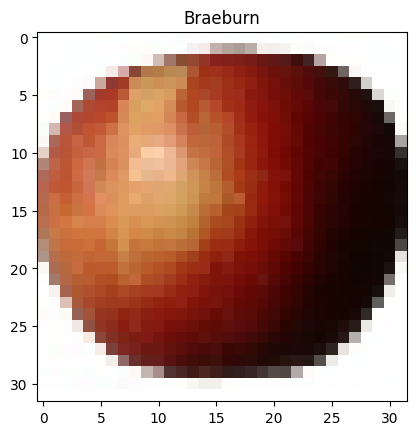

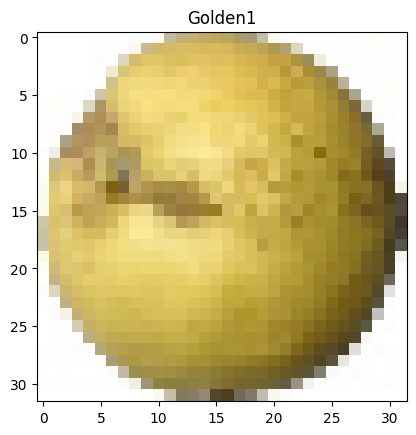

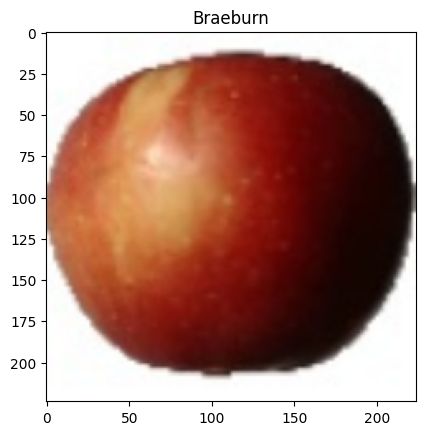

In [8]:
# Show an image of train (LQ)
plt.imshow(X_train[0])
plt.title(y_train[0])
plt.show()

# Show an image of test (LQ)
plt.imshow(X_test[400])
plt.title(y_test[400])
plt.show()

# Show an image of test (High Quality)
plt.imshow(X_test_224[0])
plt.title(y_test_224[0])
plt.show()

Now, we create a function that expects **data batches** in NumPy array format.

In [9]:
def show_images_batch(apples, names=[], n_cols=5, size_scale=2):
    """
    Display a batch of images in a grid format.

    Parameters
    ----------
    apples : list or array-like
        A list or array of images to display.
    names : list, optional
        A list of titles for each image. If provided, each image will be 
        displayed with its corresponding title. Default is an empty list.
    n_cols : int, optional
        The number of columns in the grid. Default is 5.
    size_scale : float, optional
        A scaling factor to adjust the size of the displayed images. 
        Default is 2.

    Returns
    -------
    None
        The function displays the images but does not return any value.

    Notes
    -----
    The function calculates the required number of rows based on the total 
    number of images and the specified number of columns. It then creates 
    a grid layout to display the images. If the `names` list is provided, 
    each image will have a title. The size of the figure can be adjusted 
    using the `size_scale` parameter.
    """
    n_rows = ((len(apples) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1 * size_scale))
    for index, apple in enumerate(apples):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(apple)
        plt.axis("off")
        if len(names):
            plt.title(names[index])


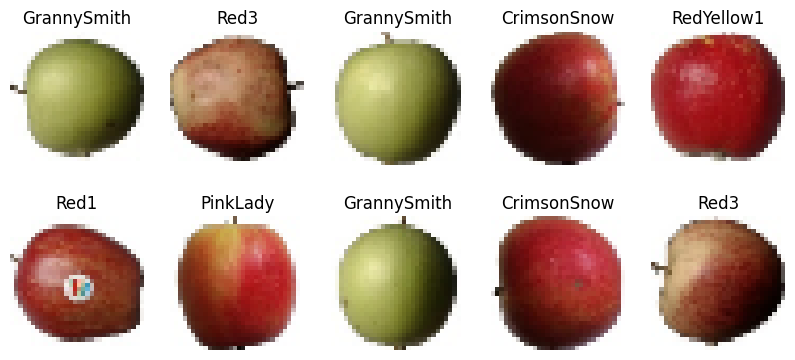

In [10]:
indexes = np.random.randint(0, len(X_train), 10)
show_images_batch(X_train[indexes], y_train[indexes])

Let's take a look at some of the 224x224 resolution images.

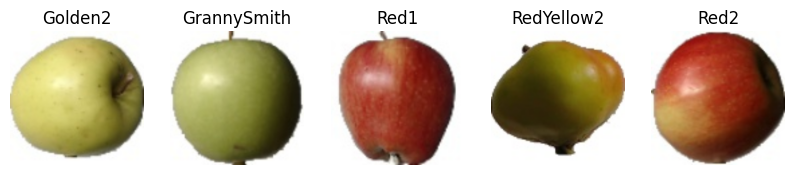

In [11]:
indexes = np.random.randint(0, len(X_test_224), 5)
show_images_batch(X_test_224[indexes], y_test_224[indexes])

## Mini-EDA

We will complete a basic EDA using image samples, and choose an evaluation **metric** for the model.

In [12]:
# Target distribution
pd.DataFrame(y_train).value_counts(normalize=True)

0           
RedYellow2      0.104934
Golden2         0.076827
Red2            0.076827
GrannySmith     0.076827
Braeburn        0.076827
RedYellow1      0.076827
Red1            0.076827
RedDelicious    0.076515
Golden3         0.075109
Golden1         0.074953
PinkLady        0.071205
CrimsonSnow     0.069332
Red3            0.066989
Name: proportion, dtype: float64

There are quite a few categories, so we are going to plot them.

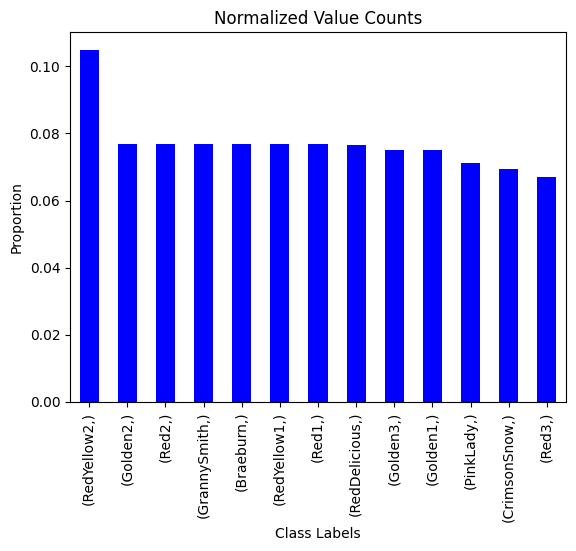

In [13]:
pd.DataFrame(y_train).value_counts(normalize=True).plot(kind="bar", color="blue")

plt.title("Normalized Value Counts")
plt.ylabel("Proportion")
plt.xlabel("Class Labels")
plt.show()

### Conclusion

We have 13 classes with a roughly uniform distribution, except for RedYellow2, which is slightly overrepresented.

In a real-world scenario, we could try applying **undersampling** to this category if the model's performance is not satisfactory. For the remaining project, we will work with this distribution and use **accuracy** as the evaluation metric.

## Data Pre-Processing and Mapping

Next, we will finalize the data preprocessing. 

Although **Keras training includes internal shuffling**, we will explicitly shuffle the training data (X_train) to facilitate smoother initial convergence of the model. We will use shuffle from sklearn and assign the shuffled data to a new variable, so the original X_train remains unchanged. There is no need to shuffle the test data.


In [14]:
# Image scaling
X_train = X_train / 255
X_test = X_test / 255

# Data shuffling. Only shuffle the training data because the model learns from them
X_train, y_train = shuffle(X_train, y_train,random_state=42)

While sklearn supports working with textual labels directly, Keras requires numerical labels. 

In the following steps, we will convert the textual labels into numerical classes. To facilitate this, we will create two dictionaries: one to map labels to their corresponding numerical classes, and another for the inverse mapping from numerical classes back to labels.

In [15]:
# Map categories to numbers and convert to dictionary
mapping = {cat: i for i, cat in enumerate(np.unique(y_train))}
inverse_mapping = {valor:clave for clave,valor in mapping.items()}

display(mapping)
display(inverse_mapping)

# Map the labels to numbers
y_train_num = np.array([mapping[cat] for cat in y_train])
y_test_num = np.array([mapping[cat] for cat in y_test])

{np.str_('Braeburn'): 0,
 np.str_('CrimsonSnow'): 1,
 np.str_('Golden1'): 2,
 np.str_('Golden2'): 3,
 np.str_('Golden3'): 4,
 np.str_('GrannySmith'): 5,
 np.str_('PinkLady'): 6,
 np.str_('Red1'): 7,
 np.str_('Red2'): 8,
 np.str_('Red3'): 9,
 np.str_('RedDelicious'): 10,
 np.str_('RedYellow1'): 11,
 np.str_('RedYellow2'): 12}

{0: np.str_('Braeburn'),
 1: np.str_('CrimsonSnow'),
 2: np.str_('Golden1'),
 3: np.str_('Golden2'),
 4: np.str_('Golden3'),
 5: np.str_('GrannySmith'),
 6: np.str_('PinkLady'),
 7: np.str_('Red1'),
 8: np.str_('Red2'),
 9: np.str_('Red3'),
 10: np.str_('RedDelicious'),
 11: np.str_('RedYellow1'),
 12: np.str_('RedYellow2')}

A more elegant and convenient way to handle this transformation is by using `LabelEncoder` from sklearn

In [16]:
# Codificado del target
le = LabelEncoder()

y_train_num = le.fit_transform(y_train)
y_test_num = le.transform(y_test)

# Mostrar el mapeo original --> codificado
for original_class, encoded_class in zip(le.classes_, range(len(le.classes_))):
    print(f"{original_class} --> {encoded_class}")

Braeburn --> 0
CrimsonSnow --> 1
Golden1 --> 2
Golden2 --> 3
Golden3 --> 4
GrannySmith --> 5
PinkLady --> 6
Red1 --> 7
Red2 --> 8
Red3 --> 9
RedDelicious --> 10
RedYellow1 --> 11
RedYellow2 --> 12


In [17]:
y_train

array(['GrannySmith', 'RedYellow1', 'GrannySmith', ..., 'RedDelicious',
       'RedYellow1', 'CrimsonSnow'], dtype='<U12')

In [18]:
y_train_num

array([ 5, 11,  5, ..., 10, 11,  1])

## Zero-Shot Learning

We will now download the pre-trained `ResNet50 model`, ready to be used directly for zero-shot learning. Keep in mind that this model has been trained on a fixed set of categories from **ImageNet**, which may differ from the labels in our dataset.

Next, we will test the model on a selection of random images from the test set. Since we are not using our custom categories, we will compare the predicted labels provided by ResNet with the actual labels in our dataset. This will help us to evaluate whether this pre-trained classifier is suitable for our specific task in its current form.

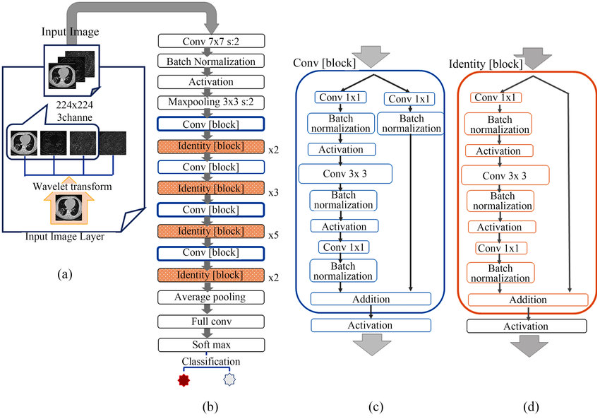

**NOTE:** Since **ResNet50V2** expects inputs of shape (224, 224, 3), attempting to use the original 32x32 images will result in an error. We will need to resize the images before passing them to the model.

In [19]:
"""
ImageNet is a large-scale image dataset used to train models like ResNet50V2.
More information can be found at: http://www.image-net.org/

We will now load the full pre-trained network and use it to make predictions.
include_top=True --> Includes the fully connected (FC) classification layers at the top of the model.
include_top=False --> Excludes the top layers so we can add a custom classifier.
Be careful with the `input_shape`, which must match the dimensions of the input images. ResNet50V2 requires inputs of size 224x224.
classifier_activation is used only if `include_top=True`.
"""

# include_top=True --> Since we are going to use the model directly for inference,
# we keep the final dense layers that perform image classification.
# weights="imagenet" --> Loads the weights trained on the ImageNet dataset.
base_model = ResNet50V2(input_shape=(IM_SIZE_HQ, IM_SIZE_HQ, 3),
                        include_top=True,
                        weights="imagenet",
                        classifier_activation="softmax")


In [20]:
# Predictions on a random selection from the test set
selection = np.random.randint(0, len(X_test_224), 10)
pred_proba = base_model.predict(X_test_224[selection])
display(pred_proba)



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [21]:
decode_predictions(pred_proba)[0]

[('n02883205', 'bow_tie', np.float32(0.9999994)),
 ('n02123597', 'Siamese_cat', np.float32(6.317445e-07)),
 ('n03706229', 'magnetic_compass', np.float32(1.2677036e-26)),
 ('n12985857', 'coral_fungus', np.float32(0.0)),
 ('n01440764', 'tench', np.float32(0.0))]

In [22]:
decode_predictions(pred_proba)[0][0]

('n02883205', 'bow_tie', np.float32(0.9999994))

In [23]:
decode_predictions(pred_proba)[0][0][1]

'bow_tie'

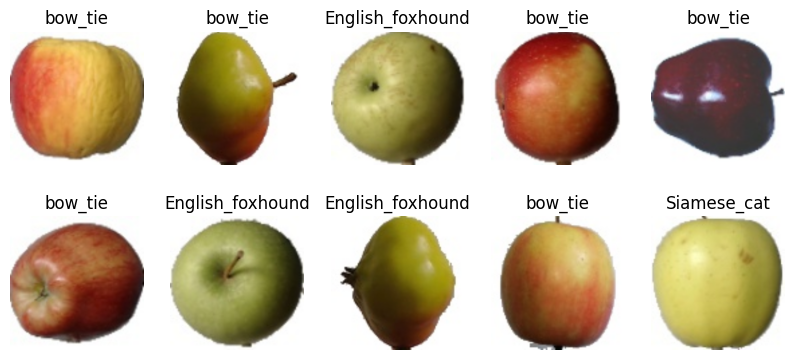

In [24]:
pred_class = [decoded[0][1] for decoded in decode_predictions(pred_proba)]
show_images_batch(X_test_224[selection], names=pred_class)

### Fail!

A small... setback arises because the classes predicted by ResNet50V2 do not match our own dataset's classes. However, the model might classify images into semantically similar categories, which suggests the possibility of creating a mapping between the two label sets.

To achieve better performance aligned with our specific categories, applying `Transfer Learning` or `Fine-Tuning` will be necessary.

## Transfer Learning

We will now load the ResNet50 model without the classification head (include_top=False). Using this as our base, we will build a new model by adding a custom classification head composed of two dense layers: one hidden layer with 300 units and ReLU activation, and a final output layer with the number of units matching our problem’s classes and an appropriate activation function.

To leverage the pre-trained features effectively, we will freeze all layers of the ResNet50 base model so that only the new head layers are trainable.

Next, we will define the necessary hyperparameters to compile the model, including the optimizer, loss function, and metrics, then compile it and display a summary.

In [25]:
# Load the pre-trained model
base_model = ResNet50V2(include_top=False, 
                        weights="imagenet", 
                        input_shape=(IM_SIZE_LQ, IM_SIZE_LQ, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# We create it this way to be able to reinitialize it in each retraining in later exercises
def prepare_TL_model(base_model):
    """
    Prepare and compile a neural network model using a base model.
    """
    # Flatten the output of the base model
    x = keras.layers.Flatten()(base_model.output)

    # Dense layer with 300 neurons
    x = keras.layers.Dense(300, activation="relu")(x)
    x = keras.layers.Dropout(rate=0.5)(x)

    # Final output layer with 13 neurons and softmax activation
    x = keras.layers.Dense(13, activation="softmax")(x)

    model = keras.Model(base_model.input, x)
    
    model.compile(optimizer="adam", 
                  loss="sparse_categorical_crossentropy", 
                  metrics = ["acc"])
    
    return model

# Show architecture of the model
model = prepare_TL_model(base_model=base_model)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │          0 │ conv2_block1_pre… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 10, 10,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 8, 8, 256) │          0 │ conv2_block1_0_c

 Total params: 24,183,413 (92.25 MB)

 Trainable params: 618,613 (2.36 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Now, we train the model using our training data and monitor the training progress. We use an `EarlyStopping` callback with a patience of 5 epochs to prevent overfitting and stop training early if the validation loss does not improve.

But let's complete the selection of the batch size and the number of epochs before starting the training.

In [26]:
X_train.shape

(6404, 32, 32, 3)

In [27]:
train_instances = len(X_train)
for i in range(1, 5):
    print(f"Batch_size: {32*i}, num_steps_per_epoch: {round(train_instances/(32*i))}")

Batch_size: 32, num_steps_per_epoch: 200
Batch_size: 64, num_steps_per_epoch: 100
Batch_size: 96, num_steps_per_epoch: 67
Batch_size: 128, num_steps_per_epoch: 50


Initially, we considered using a batch size of 64, aiming for roughly 100 steps per epoch—an intuitive starting point.

However, reconsidering and taking advantage of available computational resources, we will increase the batch size to 128. Before proceeding, we will measure the time it takes to complete a single training epoch with this configuration.

In [28]:
# Train the model with EarlyStopping
batch_size = 128
epochs = 1

model = prepare_TL_model(base_model=base_model)

cb_earlystopping = keras.callbacks.EarlyStopping(monitor="val_loss",
                                                 patience=5,
                                                 restore_best_weights=True)

t_init = time()
history = model.fit(x=X_train,
                    y=y_train_num,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[cb_earlystopping],
                    validation_split=0.2
                    )
t_end = time()
print("Fitting time:", t_end - t_init, "seconds.")

41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - acc: 0.3968 - loss: 2.3289 - val_acc: 0.9118 - val_loss: 0.4038
Fitting time: 9.408827304840088 seconds.


In our case, one epoch took about 10 seconds, but the validation accuracy was unrealistically high, indicating strong overfitting. We will confirm this once we evaluate the model on the test set.

Now, we will increase the number of epochs and proceed with training the model. 

**IMPORTANT:** we need to recreate the base model to ensure training starts fresh, rather than continuing from the previous checkpoint.

Epoch 1/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - acc: 0.3761 - loss: 2.5985 - val_acc: 0.9063 - val_loss: 0.4255
Epoch 2/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - acc: 0.8532 - loss: 0.4883 - val_acc: 0.9508 - val_loss: 0.1915
Epoch 3/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - acc: 0.9012 - loss: 0.3076 - val_acc: 0.9859 - val_loss: 0.1147
Epoch 4/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - acc: 0.9598 - loss: 0.1665 - val_acc: 0.9914 - val_loss: 0.0658
Epoch 5/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - acc: 0.9746 - loss: 0.1149 - val_acc: 0.9945 - val_loss: 0.0545
Epoch 6/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - acc: 0.9739 - loss: 0.1016 - val_acc: 0.9969 - val_loss: 0.0338
Epoch 7/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - acc: 0.9884 - loss: 0.0609 - val_acc: 0.9992 - val_loss: 0.0240
Epoch 8/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - acc: 0.9895 - loss: 0.0545 - val_acc: 0.9992 - val_loss: 0.0225
Epoch 9/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - ac

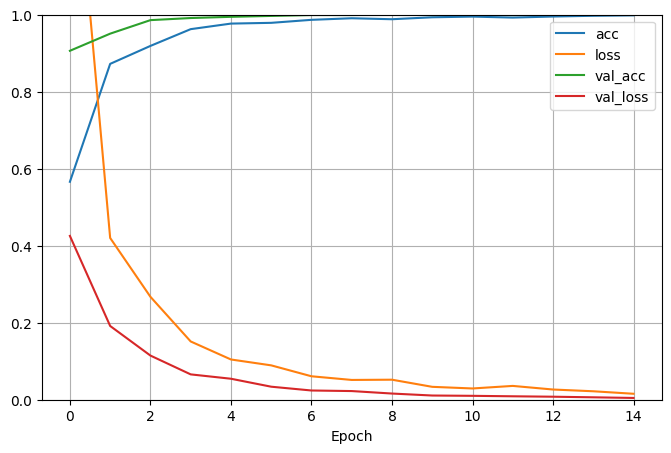

In [29]:
# Train the model with EarlyStopping
batch_size = 128
epochs = 15

model = prepare_TL_model(base_model=base_model)

cb_earlystopping = keras.callbacks.EarlyStopping(monitor="val_loss",
                                                 patience=5,
                                                 restore_best_weights=True)

t_init = time()
history = model.fit(x=X_train,
                    y=y_train_num,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[cb_earlystopping],
                    validation_split=0.2
                    )
t_end = time()
print("Fitting time:", t_end - t_init, "seconds.")

# We can see how the training evolves, depending on the epochs
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel("Epoch")
plt.show()

Clearly, even without plotting the training progress, the accuracy values are excessively high. Considering that ResNet architectures are prone to overfitting, it is advisable to incorporate stronger regularization. This can be done, for example, by adding L2 regularization through the optimizer’s weight_decay parameter or by applying it directly to individual layers (refer to the Keras documentation for details). In the next section, we will analyze how much the accuracy decreases when evaluated on the test set.

Moreover, the loss continues to decrease steadily. To avoid unnecessarily long training, we could implement a tolerance mechanism to stop training earlier. For example:

Epoch 1/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - acc: 0.3774 - loss: 2.4441 - val_acc: 0.8985 - val_loss: 0.4448
Epoch 2/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - acc: 0.8508 - loss: 0.4961 - val_acc: 0.9547 - val_loss: 0.2104
Epoch 3/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - acc: 0.9094 - loss: 0.2924 - val_acc: 0.9859 - val_loss: 0.1071
Epoch 4/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - acc: 0.9584 - loss: 0.1696 - val_acc: 0.9953 - val_loss: 0.0682
Epoch 5/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - acc: 0.9771 - loss: 0.1090 - val_acc: 0.9953 - val_loss: 0.0472
Epoch 6/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - acc: 0.9744 - loss: 0.1005 - val_acc: 0.9906 - val_loss: 0.0436
Epoch 7/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - acc: 0.9817 - loss: 0.0800 - val_acc: 0.9953 - val_loss: 0.0306
Epoch 8/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - acc: 0.9759 - loss: 0.0864 - val_acc: 0.9992 - val_loss: 0.0241
Fitting time: 42.54649758338928 seconds.


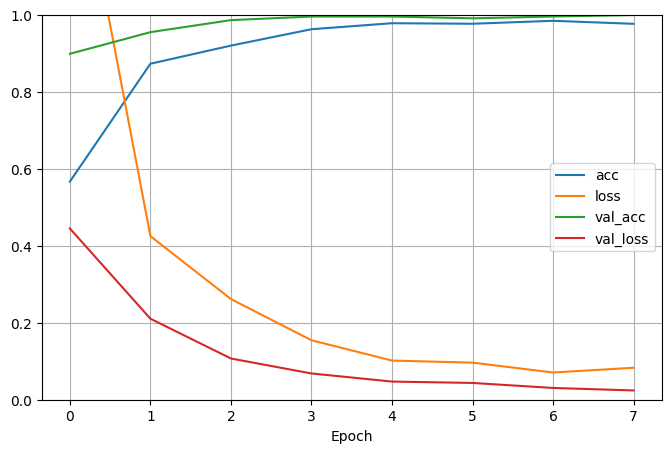

In [30]:
# Train the model with EarlyStopping modified
batch_size = 128
epochs = 15

model = prepare_TL_model(base_model=base_model)

cb_earlystopping = keras.callbacks.EarlyStopping(monitor="val_loss",
                                                 min_delta=0.1, 
                                                 patience=5,
                                                 restore_best_weights= True
                                                 )

t_init = time()
history = model.fit(x=X_train,
                    y=y_train_num,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[cb_earlystopping],
                    validation_split=0.2
                    )
t_end = time()
print("Fitting time:", t_end - t_init, "seconds.")

# Evolution of the training, depending on the epochs
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel('Epoch')
plt.show()

## Train vs Test Analysis

Now, we will evaluate the trained model on the test dataset and analyze the differences in performance compared to training and validation.

First, we will generate a classification report including precision, recall, and F1-score for each class. Additionally, we will compute and visualize the confusion matrix to better understand which classes are most frequently confused.

Finally, we will perform a brief error analysis to identify common patterns in misclassifications and discuss potential causes and remedies.

In [31]:
# Model evaluation
model.evaluate(X_test, y_test_num)

67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - acc: 0.7807 - loss: 0.5751


[0.5897013545036316, 0.7910028100013733]

Given the model’s high capacity, it is expected to overfit. Besides applying possible regularization techniques or adding dropout layers, reducing the number of units in the dense layer could also help mitigate overfitting.

Nevertheless, achieving over 80% accuracy at this stage without further tuning is a promising start.

67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step
              precision    recall  f1-score   support

    Braeburn       0.83      0.77      0.80       164
 CrimsonSnow       0.78      0.85      0.82       148
     Golden1       0.74      0.96      0.83       160
     Golden2       0.99      0.59      0.74       164
     Golden3       0.48      0.52      0.50       161
 GrannySmith       0.98      0.79      0.88       164
    PinkLady       0.78      0.78      0.78       152
        Red1       0.93      0.65      0.77       164
        Red2       0.50      0.69      0.58       164
        Red3       0.96      0.65      0.78       144
RedDelicious       1.00      0.99      1.00       166
  RedYellow1       0.68      0.99      0.81       164
  RedYellow2       0.99      0.97      0.98       219

    accuracy                           0.79      2134
   macro avg       0.82      0.79      0.79      2134
weighted avg       0.82      0.79      0.79      2134



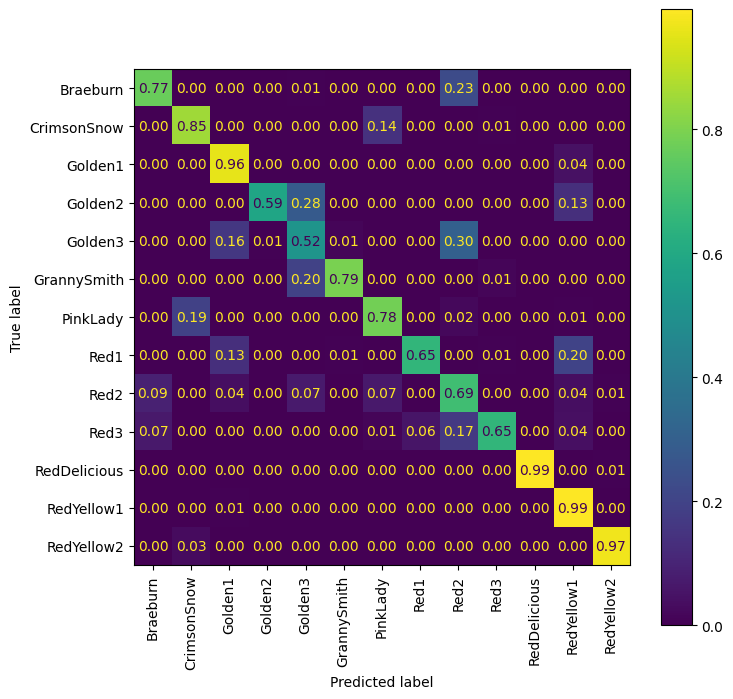

In [32]:
# Prediction
y_pred_num = np.array([np.argmax(pred_proba) for pred_proba in model.predict(X_test)])
y_pred = le.inverse_transform(y_pred_num)

# Classification Report
print(classification_report(y_test, y_pred))

# Confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true", ax=ax, values_format='.2f')
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

The overall performance is quite good, although some types still present challenges. Specifically, the Golden3 class tends to be confused with Golden1 and Red2.

On the other hand, there are impressive successes in classes like RedX, Deliciousm Yellow1, Yellow2, as well as Golden type 1, Golden type 2, and Braeburn.

Visually, let’s examine some of the misclassifications by analyzing a results dataframe.


In [33]:
results = pd.DataFrame({"True": y_test, "Predicted": y_pred})

errors = results["True"] != results["Predicted"]
is_Golden3 = results["True"] == "Golden3"
predicted_Red2 = results["Predicted"] == "Red2"
is_Red2 = results["True"] == "Red2"


Let’s display the instances of Golden3 that the model has misclassified as Red2. It’s important to note that Golden3 is one of the classes the model struggles with the most.

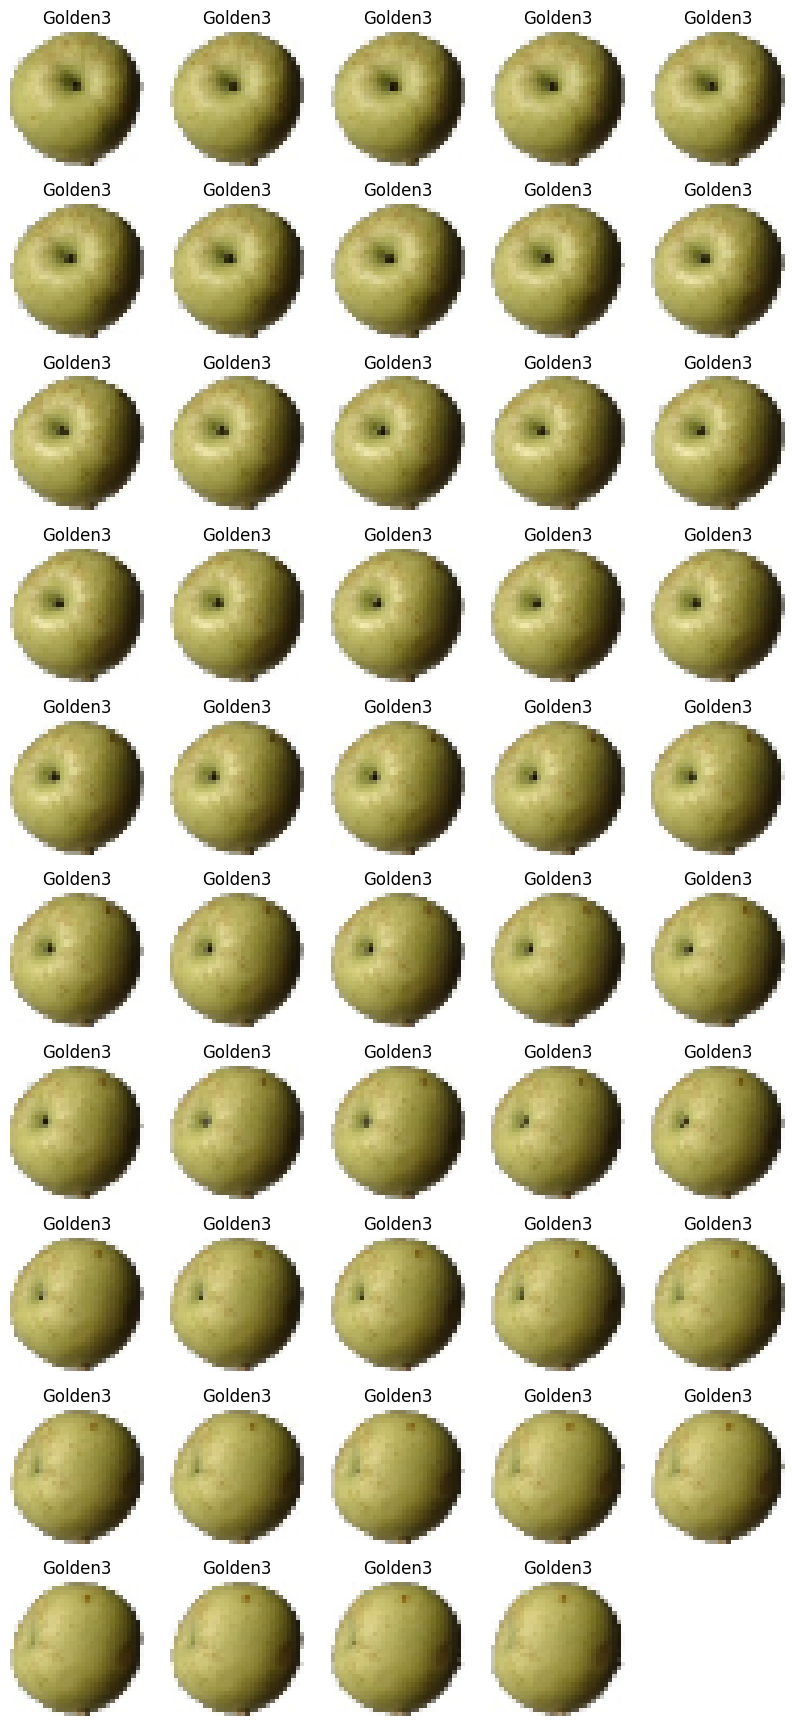

In [34]:
show_images_batch(X_test[results[is_Golden3 & predicted_Red2].index],
                  y_test[results[is_Golden3 & predicted_Red2].index])

To compare, let’s also display some Red2 images that the model correctly classified.

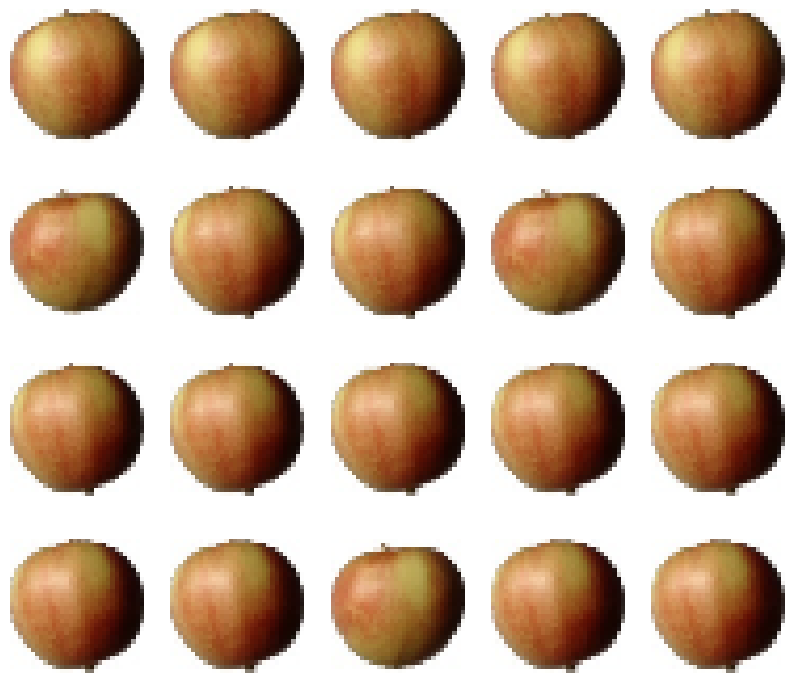

In [35]:
show_images_batch(X_test[results[is_Red2 & predicted_Red2].index[20:40]])

And here are some Golden3 examples that the model correctly labeled.


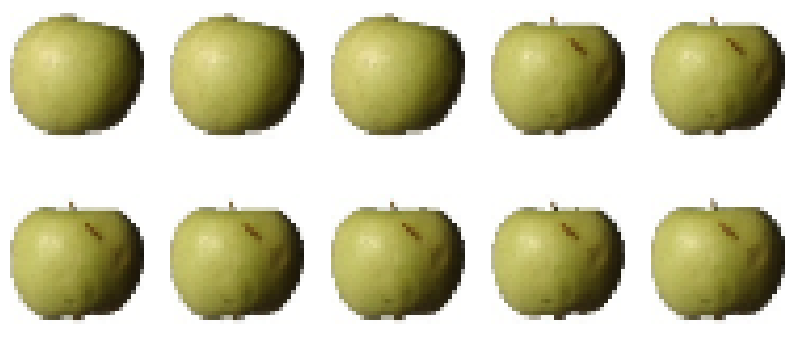

In [36]:
show_images_batch(X_test[results[is_Golden3 & (errors == False)].index[0:10]])


## Fine Tuning

Now, we will proceed with fine tuning.

First, we download the ResNet50 model without pre-trained weights and without the classification head. Then, we create the same custom model architecture as previously by adding the two dense layers (hidden layer with 300 units and ReLU activation, and output layer with the appropriate units and activation).

Afterward, we will compile the model and display its summary.

In [37]:
# Load the pre-trained model
base_model = ResNet50V2(include_top=False, 
                        weights=None, 
                        input_shape=(IM_SIZE_LQ, IM_SIZE_LQ, 3))

# Now we do NOT want to freeze the layers of the base model
# for layer in base_model.layers:
#     layer.trainable = False

# We will use the same model as before, but now we will not freeze the layers
def prepare_FT_model(base_model):
    """
    Prepare and compile a neural network model using a base model, for Fine Tuning.
    """
    # Flatten the output of the base model
    x = keras.layers.Flatten()(base_model.output)

    # Dense layer with 300 neurons
    x = keras.layers.Dense(300, activation="relu")(x)
    x = keras.layers.Dropout(rate=0.5)(x)

    # Final output layer with 13 neurons and softmax activation
    x = keras.layers.Dense(13, activation="softmax")(x)

    model = keras.Model(base_model.input, x)
    model.compile(optimizer="adam", 
                  loss="sparse_categorical_crossentropy", 
                  metrics = ["acc"]
                  )
    return model

# Model summary and architecture
model= prepare_FT_model(base_model=base_model)
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │          0 │ conv2_block1_pre… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 10, 10,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 8, 8, 256) │          0 │ conv2_block1_0_c

 Total params: 24,183,413 (92.25 MB)

 Trainable params: 24,137,973 (92.08 MB)

 Non-trainable params: 45,440 (177.50 KB)

We will train the model using a batch size of 64 and for 60 epochs, applying an EarlyStopping callback with a patience of 10. Given that this training process is significantly longer... feel free to take a break while it runs.


Epoch 1/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 285ms/step - acc: 0.6778 - loss: 1.1024 - val_acc: 0.0859 - val_loss: 2.8669
Epoch 2/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 22s 268ms/step - acc: 0.9498 - loss: 0.1880 - val_acc: 0.0695 - val_loss: 4.5636
Epoch 3/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 22s 273ms/step - acc: 0.8533 - loss: 0.5075 - val_acc: 0.0804 - val_loss: 15.8957
Epoch 4/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 22s 270ms/step - acc: 0.8251 - loss: 0.5865 - val_acc: 0.1241 - val_loss: 48.6939
Epoch 5/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 22s 268ms/step - acc: 0.8952 - loss: 0.3444 - val_acc: 0.1460 - val_loss: 43.0287
Epoch 6/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 22s 271ms/step - acc: 0.9577 - loss: 0.1558 - val_acc: 0.1686 - val_loss: 34.5390
Epoch 7/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 265ms/step - acc: 0.7009 - loss: 1.2836 - val_acc: 0.0695 - val_loss: 67.6115
Epoch 8/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 22s 274ms/step - acc: 0.9261 - loss: 0.2333 - val_acc: 0.3591 - val_loss: 3.4686
Epoch 9/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 23s 2

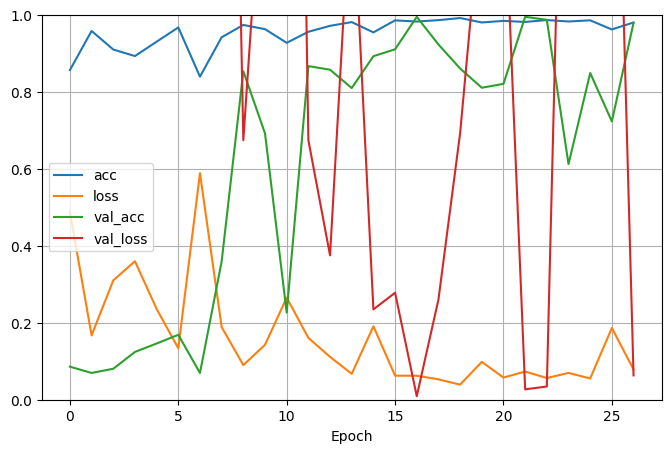

In [38]:
batch_size = 64
epochs = 60

model = prepare_FT_model(base_model=base_model)

cb_earlystopping = keras.callbacks.EarlyStopping(monitor="val_loss",
                                                 patience=10,
                                                 restore_best_weights=True
                                                 )

# Train the model
t_init = time()
history = model.fit(X_train,
                    y_train_num,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,
                    callbacks=[cb_earlystopping]
                    )
t_end = time()
print("Fitting time:", t_end - t_init, "seconds.")

# Evolution of training, depending on epochs
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel("Epoch")
plt.show()

Let’s zoom out to better observe the fluctuations in the validation loss ("val_loss").


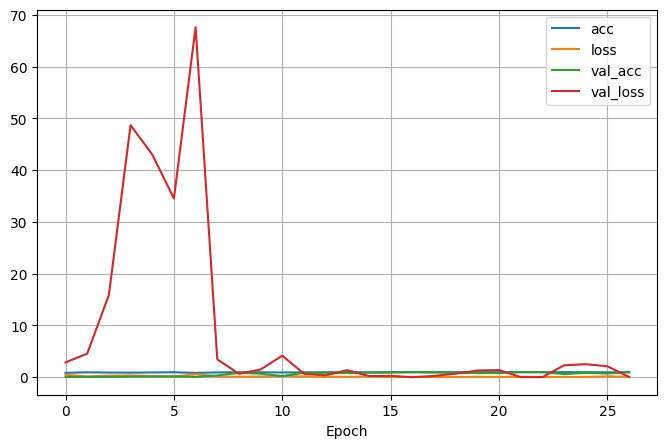

In [39]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 90)
plt.xlabel('Epoch')
plt.show()

The challenge with large networks and the limited amount of data we have is that the results tend to fluctuate significantly, and the training process is highly sensitive to weight initialization. The model often takes time to reach low validation loss values, and if you repeat the training process, it may take more or less time to converge to meaningful solutions.

Increasing the batch size could help mitigate the effects of random sampling, making the training more stable.

What is clear is that choosing a small number of epochs may prevent the model from properly "warming up" and escaping local minima, resulting in suboptimal performance.

As you can see, fine-tuning large models requires both data and patience.

## Test Evaluation

In [40]:
model.evaluate(X_test, y_test_num)

67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - acc: 0.9574 - loss: 0.0932


[0.0785759836435318, 0.9676663279533386]

For this test set, patience — along with the powerful model — has paid off, at least in this particular run. However, keep in mind that future executions may not yield equally good results.

67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step
              precision    recall  f1-score   support

    Braeburn       0.83      0.90      0.86       164
 CrimsonSnow       1.00      1.00      1.00       148
     Golden1       1.00      0.90      0.95       160
     Golden2       1.00      1.00      1.00       164
     Golden3       1.00      0.96      0.98       161
 GrannySmith       0.96      1.00      0.98       164
    PinkLady       1.00      1.00      1.00       152
        Red1       1.00      1.00      1.00       164
        Red2       0.84      0.99      0.91       164
        Red3       1.00      0.80      0.89       144
RedDelicious       1.00      1.00      1.00       166
  RedYellow1       1.00      1.00      1.00       164
  RedYellow2       1.00      1.00      1.00       219

    accuracy                           0.97      2134
   macro avg       0.97      0.97      0.97      2134
weighted avg       0.97      0.97      0.97      2134



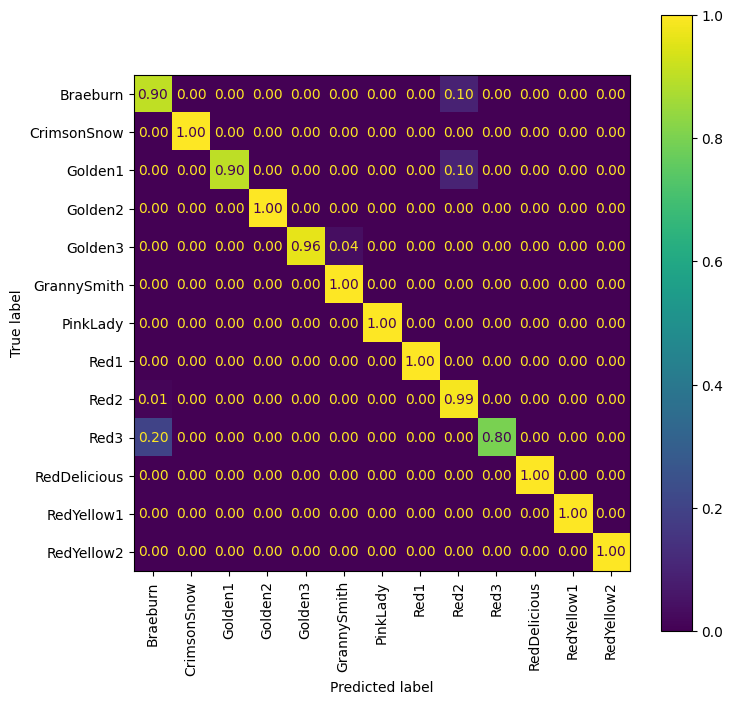

In [41]:
# Prediction
y_pred_num = np.array([np.argmax(pred_proba) for pred_proba in model.predict(X_test)])
y_pred = le.inverse_transform(y_pred_num)

# Classification Report
print(classification_report(y_test, y_pred))

# Confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true", ax=ax, values_format=".2f")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

## Delete big files and folders


In [42]:
# Delete the folders created in this notebook
data_path = '../data/apple/'
consolepy.remove_non_zip_folders(data_path)
consolepy.remove_npy_files(data_path)

Removing folder: ../data/apple/apple_test\Braeburn
Removing folder: ../data/apple/apple_test\CrimsonSnow
Removing folder: ../data/apple/apple_test\Golden1
Removing folder: ../data/apple/apple_test\Golden2
Removing folder: ../data/apple/apple_test\Golden3
Removing folder: ../data/apple/apple_test\GrannySmith
Removing folder: ../data/apple/apple_test\PinkLady
Removing folder: ../data/apple/apple_test\Red1
Removing folder: ../data/apple/apple_test\Red2
Removing folder: ../data/apple/apple_test\Red3
Removing folder: ../data/apple/apple_test\RedDelicious
Removing folder: ../data/apple/apple_test\RedYellow1
Removing folder: ../data/apple/apple_test\RedYellow2
Removing folder: ../data/apple/apple_test
Removing folder: ../data/apple/apple_train\Braeburn
Removing folder: ../data/apple/apple_train\CrimsonSnow
Removing folder: ../data/apple/apple_train\Golden1
Removing folder: ../data/apple/apple_train\Golden2
Removing folder: ../data/apple/apple_train\Golden3
Removing folder: ../data/apple/apple